Cluster Interconnectivity Analysis Script

This script analyzes and visualizes the interconnectivity between academic paper clusters.
It processes citation networks to show how different research clusters reference each other,
creating matrices and heatmap visualizations.

The script:

1. Loads cluster and reference data from pickle and JSON files
2. Creates interconnectivity matrices showing citation patterns between clusters
3. Analyzes internal vs. external reference patterns for each cluster
4. Generates heatmap visualizations of the interconnectivity

Requirements:

- Environment variables in .env file: DATA_DIR, OUTPUT_DIR
- Input data:
  - Pickled DataFrame with cluster assignments and reference data
  - JSON files with cluster labels and legend information

Author: Lukas Westphal
Date: April 16, 2025


In [4]:
import json
import os
from collections import defaultdict
from datetime import datetime
from typing import Dict, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from dotenv import load_dotenv
import igraph as ig
from pandas import Timestamp

In [56]:
def load_data(data_dir: str, output_dir: str) -> pd.DataFrame:
    """
    Load the dataset and reference files.

    This method loads the main DataFrame, cluster labels, and legend files
    required for the analysis. It ensures that all necessary data is available
    for subsequent operations.

    Returns:
        self: The ClusterAnalyzer instance with loaded data.
    """
    # Load DataFrame
    pdf = os.path.join(data_dir, "08-analysis-data/df_analysis.pkl")
    df = pd.read_pickle(pdf)
    print(f"DataFrame loaded with rows: {len(df)}")

    # Load graph
    pg = os.path.join(data_dir, "08-analysis-data/graph_analysis.graphml")
    g = ig.read(pg)
    print(f"Graph loaded with {g.vcount()} vertices and {g.ecount()} edges.")
    # Load cluster labels
    labels_path = os.path.join(
        output_dir,
        "cluster-qualifications_2025/cluster-label-tree/cluster_labels_filtered.json",
    )
    with open(labels_path, "r") as f:
        cluster_label_dict = json.load(f)
    print(f"Cluster labels loaded with {len(cluster_label_dict)} entries.")

    # Load legend
    legend_path = os.path.join(
        output_dir,
        "cluster-qualifications_2025/cluster-label-tree/legend_labels_2025.json",
    )
    with open(legend_path, "r") as f:
        legend = json.load(f)
    print(f"Legend loaded with {len(legend)} entries.")
    return df, g, cluster_label_dict, legend


load_dotenv()

# Access environment variables
data_dir = os.getenv("DATA_DIR")
output_dir = os.getenv("OUTPUT_DIR")

df, g, cluster_label_dict, legend = load_data(data_dir=data_dir, output_dir=output_dir)

DataFrame loaded with rows: 36510


/opt/homebrew/Caskroom/miniconda/base/envs/bibliometrics/lib/python3.11/site-packages/igraph/io/files.py:295: RuntimeWarning: Could not add vertex ids, there is already an 'id' vertex attribute. at src/io/graphml.c:488
  return reader(f, *args, **kwds)


Graph loaded with 36510 vertices and 551227 edges.
Cluster labels loaded with 99 entries.
Legend loaded with 4 entries.


In [57]:
g.es[10]

igraph.Edge(<igraph.Graph object at 0x1651d9e50>, 10, {'weight': 0.634322166442871})

In [58]:
g.vs[10]

igraph.Vertex(<igraph.Graph object at 0x1651d9e50>, 10, {'eid': '2-s2.0-0020144348', 'title': 'Serotonin and fear retention in the rat', 'year': 1982.0, 'id': '10', 'cluster': '47', 'centrality_alpha0.3_k10_res0.002': 0.0157127297097148, 'doi': '10.1037/h0077897', 'authors': 'Archer'})

In [68]:
years = list(range(1982, 2026))
print(f"Years: {years}")


# Define the time window size (e.g., 1 for yearly snapshots, 2 for bi-yearly, etc.)
time_window_size = 7  # Example: Yearly snapshots

# Create a list of time periods (e.g., [2000, 2001,..., 2014])
time_periods = range(min(years), max(years) + 1, time_window_size)

Years: [1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025]


In [113]:
import numpy as np
from collections import defaultdict

years = list(range(1982, 2026))
print(f"Years: {years}")

# Define the time window size
time_window_size = 3  # 6-year windows

# Create a list of time periods
time_periods = range(min(years), max(years) + 1, time_window_size)

temporal_data = {}

for year_start in time_periods:
    year_end = year_start + time_window_size - 1

    # Identify nodes (papers) published within this time window
    nodes_in_window = [n for n in g.vs if year_start <= n["year"] <= year_end]

    # Create snapshot graph
    snapshot_graph = g.subgraph(nodes_in_window).copy()

    # Get all clusters in the snapshot graph
    clusters = set(snapshot_graph.vs["cluster"])

    # Initialize metrics dictionaries
    cluster_metrics = {}
    inter_cluster_metrics = {}

    # Build cluster membership mapping
    cluster_nodes = defaultdict(list)
    for v in snapshot_graph.vs:
        cluster_nodes[v["cluster"]].append(v.index)

    # Calculate intra-cluster metrics
    for cluster_id in clusters:
        nodes_in_cluster = cluster_nodes[cluster_id]
        n_nodes = len(nodes_in_cluster)

        if n_nodes > 1:
            # Get subgraph for this cluster
            cluster_subgraph = snapshot_graph.subgraph(nodes_in_cluster)

            # Internal density: actual edges / possible edges
            n_edges = cluster_subgraph.ecount()
            possible_edges = n_nodes * (n_nodes - 1) / 2  # for undirected
            internal_density = n_edges / possible_edges if possible_edges > 0 else 0

            # Average internal degree (normalized by cluster size)
            avg_internal_degree = (2 * n_edges) / n_nodes if n_nodes > 0 else 0

            # Average clustering coefficient within cluster
            clustering_coeffs = cluster_subgraph.transitivity_local_undirected(
                mode="zero"
            )
            avg_clustering = np.mean(clustering_coeffs) if clustering_coeffs else 0

            cluster_metrics[cluster_id] = {
                "size": n_nodes,
                "internal_density": internal_density,
                "avg_internal_degree": avg_internal_degree,
                "avg_clustering_coefficient": avg_clustering,
                "n_internal_edges": n_edges,
            }
        else:
            cluster_metrics[cluster_id] = {
                "size": n_nodes,
                "internal_density": 0,
                "avg_internal_degree": 0,
                "avg_clustering_coefficient": 0,
                "n_internal_edges": 0,
            }

    # Calculate inter-cluster metrics
    # Build edge matrix between clusters
    cluster_edge_matrix = defaultdict(lambda: defaultdict(int))

    for edge in snapshot_graph.es:
        source_cluster = snapshot_graph.vs[edge.source]["cluster"]
        target_cluster = snapshot_graph.vs[edge.target]["cluster"]

        if source_cluster != target_cluster:
            # Inter-cluster edge
            cluster_edge_matrix[source_cluster][target_cluster] += 1
            cluster_edge_matrix[target_cluster][source_cluster] += 1  # for undirected

    # Calculate inter-cluster connectivity metrics
    total_inter_edges = (
        sum(sum(edges.values()) for edges in cluster_edge_matrix.values()) / 2
    )

    # External connectivity fraction for each cluster
    for cluster_id in clusters:
        external_edges = sum(cluster_edge_matrix[cluster_id].values())
        internal_edges = cluster_metrics[cluster_id]["n_internal_edges"]
        total_edges = external_edges + internal_edges

        external_fraction = external_edges / total_edges if total_edges > 0 else 0
        cluster_metrics[cluster_id]["external_fraction"] = external_fraction

        # Participation coefficient (how evenly edges are distributed across other clusters)
        if external_edges > 0:
            participation_values = []
            for other_cluster, n_edges in cluster_edge_matrix[cluster_id].items():
                participation_values.append((n_edges / external_edges) ** 2)
            participation_coeff = 1 - sum(participation_values)
        else:
            participation_coeff = 0

        cluster_metrics[cluster_id]["participation_coefficient"] = participation_coeff

    # Global inter-cluster metrics
    n_clusters = len(clusters)
    if n_clusters > 1:
        # Inter-cluster density
        possible_inter_edges = sum(
            cluster_metrics[c1]["size"] * cluster_metrics[c2]["size"]
            for i, c1 in enumerate(clusters)
            for c2 in list(clusters)[i + 1 :]
        )
        inter_cluster_density = (
            total_inter_edges / possible_inter_edges if possible_inter_edges > 0 else 0
        )

        # Modularity (simplified version - comparing actual vs expected edges)
        total_edges = snapshot_graph.ecount()
        if total_edges > 0:
            modularity = 0
            for c1 in clusters:
                for c2 in clusters:
                    actual_edges = (
                        cluster_edge_matrix[c1][c2] / 2
                        if c1 == c2
                        else cluster_edge_matrix[c1][c2]
                    )
                    if c1 == c2:
                        actual_edges = cluster_metrics[c1]["n_internal_edges"]

                    # Expected edges under null model
                    deg_c1 = cluster_metrics[c1]["n_internal_edges"] * 2 + sum(
                        cluster_edge_matrix[c1].values()
                    )
                    deg_c2 = cluster_metrics[c2]["n_internal_edges"] * 2 + sum(
                        cluster_edge_matrix[c2].values()
                    )
                    expected_edges = (deg_c1 * deg_c2) / (2 * total_edges)

                    if c1 == c2:
                        modularity += actual_edges - expected_edges

            modularity = modularity / total_edges
        else:
            modularity = 0
    else:
        inter_cluster_density = 0
        modularity = 0

    # Calculate global metrics
    total_internal_edges = sum(m["n_internal_edges"] for m in cluster_metrics.values())
    total_edges = snapshot_graph.ecount()
    global_inter_fraction = (
        (total_edges - total_internal_edges) / total_edges if total_edges > 0 else 0
    )

    # Average metrics across clusters (weighted by cluster size)
    total_nodes = sum(m["size"] for m in cluster_metrics.values())
    avg_internal_density = (
        sum(m["internal_density"] * m["size"] for m in cluster_metrics.values())
        / total_nodes
        if total_nodes > 0
        else 0
    )
    avg_external_fraction = (
        sum(m["external_fraction"] * m["size"] for m in cluster_metrics.values())
        / total_nodes
        if total_nodes > 0
        else 0
    )
    avg_participation_coeff = (
        sum(
            m["participation_coefficient"] * m["size"] for m in cluster_metrics.values()
        )
        / total_nodes
        if total_nodes > 0
        else 0
    )

    # Store all metrics
    temporal_data[(year_start, year_end)] = {
        "graph": snapshot_graph,
        "n_nodes": snapshot_graph.vcount(),
        "n_edges": snapshot_graph.ecount(),
        "n_clusters": n_clusters,
        "cluster_metrics": cluster_metrics,
        "global_metrics": {
            "inter_cluster_density": inter_cluster_density,
            "global_inter_fraction": global_inter_fraction,
            "avg_internal_density": avg_internal_density,
            "avg_external_fraction": avg_external_fraction,
            "avg_participation_coefficient": avg_participation_coeff,
            "modularity": modularity,
            "total_inter_edges": total_inter_edges,
            "total_internal_edges": total_internal_edges,
        },
    }

    print(f"\nPeriod {year_start}-{year_end}:")
    print(
        f"  Nodes: {snapshot_graph.vcount()}, Edges: {snapshot_graph.ecount()}, Clusters: {n_clusters}"
    )
    print(f"  Inter-cluster density: {inter_cluster_density:.4f}")
    print(f"  Global inter-fraction: {global_inter_fraction:.4f}")
    print(f"  Avg internal density: {avg_internal_density:.4f}")
    print(f"  Modularity: {modularity:.4f}")

# Optional: Extract time series of key metrics for analysis
time_series_metrics = {
    "inter_cluster_density": [],
    "global_inter_fraction": [],
    "avg_internal_density": [],
    "avg_participation_coefficient": [],
    "modularity": [],
    "n_clusters": [],
    "periods": [],
}

for (year_start, year_end), data in temporal_data.items():
    time_series_metrics["periods"].append(f"{year_start}-{year_end}")
    time_series_metrics["inter_cluster_density"].append(
        data["global_metrics"]["inter_cluster_density"]
    )
    time_series_metrics["global_inter_fraction"].append(
        data["global_metrics"]["global_inter_fraction"]
    )
    time_series_metrics["avg_internal_density"].append(
        data["global_metrics"]["avg_internal_density"]
    )
    time_series_metrics["avg_participation_coefficient"].append(
        data["global_metrics"]["avg_participation_coefficient"]
    )
    time_series_metrics["modularity"].append(data["global_metrics"]["modularity"])
    time_series_metrics["n_clusters"].append(data["n_clusters"])

Years: [1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025]

Period 1982-1984:
  Nodes: 235, Edges: 274, Clusters: 44
  Inter-cluster density: 0.0036
  Global inter-fraction: 0.3431
  Avg internal density: 0.1710
  Modularity: 0.4852

Period 1985-1987:
  Nodes: 331, Edges: 448, Clusters: 51
  Inter-cluster density: 0.0031
  Global inter-fraction: 0.3616
  Avg internal density: 0.1494
  Modularity: 0.4773

Period 1988-1990:
  Nodes: 514, Edges: 633, Clusters: 62
  Inter-cluster density: 0.0010
  Global inter-fraction: 0.2022
  Avg internal density: 0.1105
  Modularity: 0.5559

Period 1991-1993:
  Nodes: 1045, Edges: 1865, Clusters: 85
  Inter-cluster density: 0.0011
  Global inter-fraction: 0.3185
  Avg internal density: 0.1110
  Modularity: 0.5228

Period 1994-1996:
  Nodes: 16

In [114]:
cluster_metrics["0"]

{'size': 145,
 'internal_density': 0.026436781609195402,
 'avg_internal_degree': 3.806896551724138,
 'avg_clustering_coefficient': np.float64(0.25193507618083255),
 'n_internal_edges': 276,
 'external_fraction': 0.1320754716981132,
 'participation_coefficient': 0.6564625850340138}

In [115]:
time_series_metrics

{'inter_cluster_density': [0.00361357782647138,
  0.003110300470384948,
  0.0010183218374344655,
  0.0011281772719761904,
  0.0008866837311460208,
  0.0006757821710781034,
  0.0005284225017506744,
  0.00040704647460901045,
  0.00038595848862754527,
  0.0003012595480792147,
  0.00025818223449973195,
  0.0002604506941432298,
  0.00023107021387076674,
  0.0003034741597946285,
  0.0003628683457447858],
 'global_inter_fraction': [0.34306569343065696,
  0.36160714285714285,
  0.20221169036334913,
  0.3184986595174263,
  0.3438368860055607,
  0.34537725823591925,
  0.3387713997985901,
  0.31441774491682073,
  0.3224885844748858,
  0.2983795574945466,
  0.29396078431372547,
  0.28735951158595807,
  0.2487798075582206,
  0.2552312528064661,
  0.2665788317962231],
 'avg_internal_density': [0.17101694524958533,
  0.14938208177634157,
  0.1105123657492338,
  0.1110203629082568,
  0.09596790982278179,
  0.08267765668881859,
  0.07068200069035857,
  0.06742590321725472,
  0.0625084957147072,
  0.055

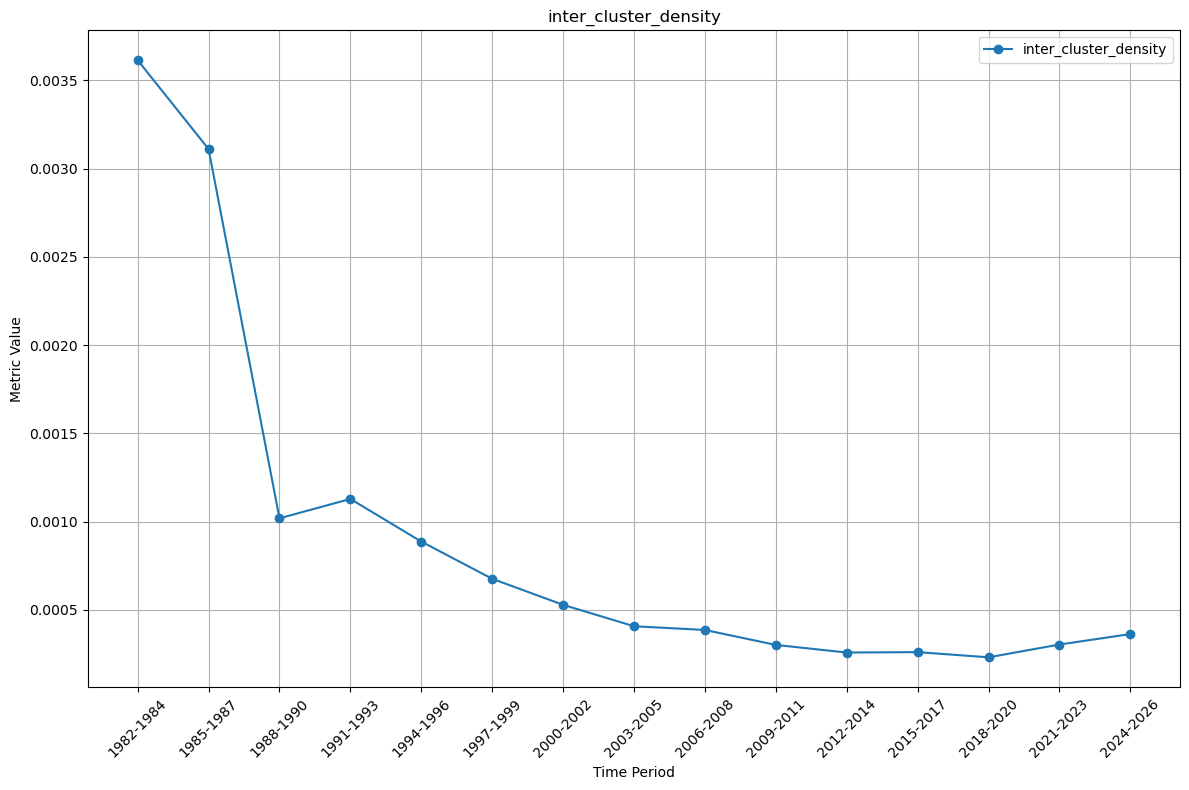

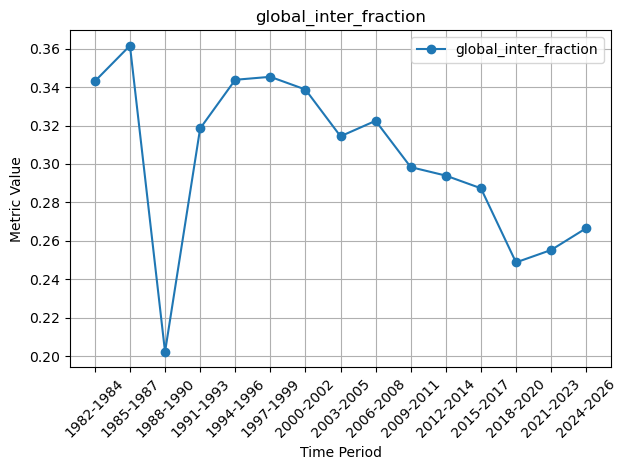

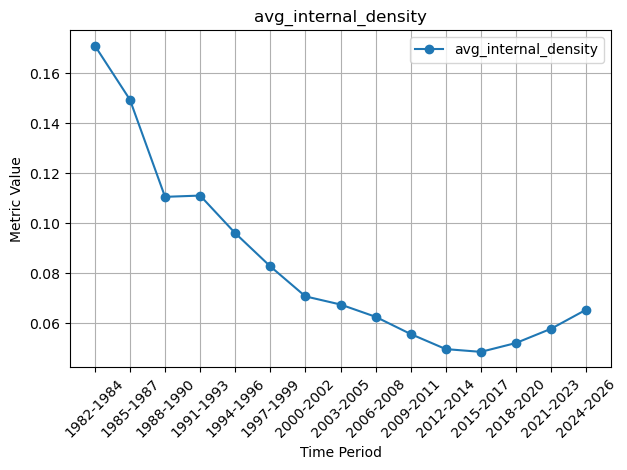

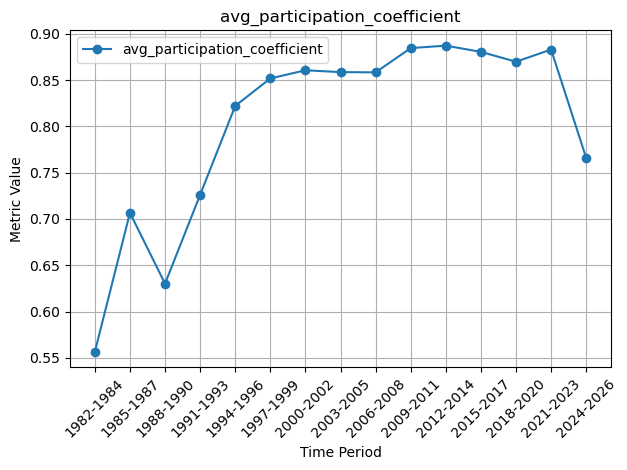

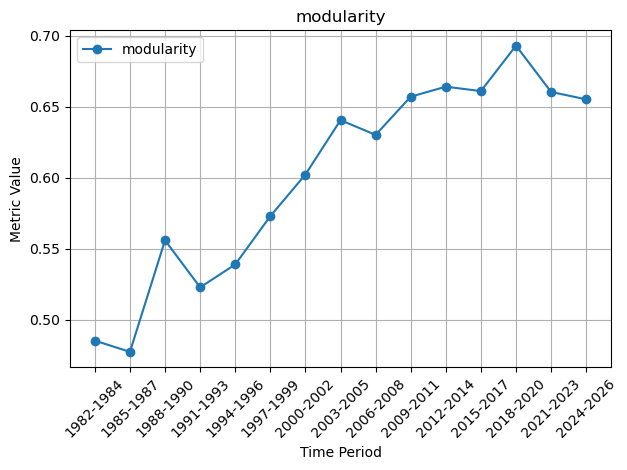

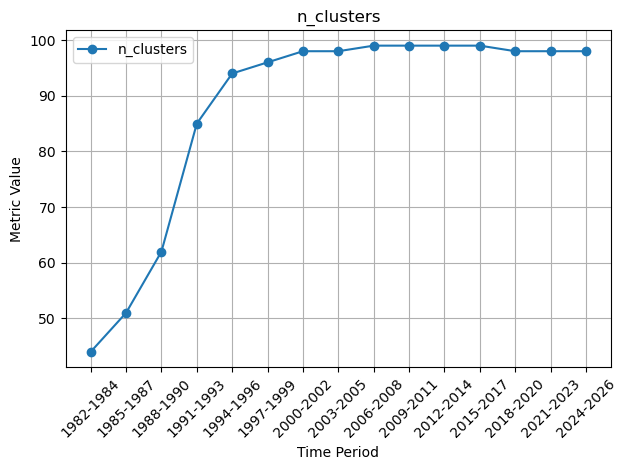

In [116]:
# plot all metrics
def plot_time_series(
    metrics: Dict[str, List[float]],
):
    plt.figure(figsize=(12, 8))
    for key, values in metrics.items():
        if key != "periods":
            plt.plot(metrics["periods"], values, marker="o", label=key)
            plt.title(key)
            plt.xlabel("Time Period")
            plt.ylabel("Metric Value")
            plt.xticks(rotation=45)
            plt.legend()
            plt.grid()
            plt.tight_layout()
            plt.show()


plot_time_series(time_series_metrics)

In [107]:
temporal_data[(1982, 1987)]

{'graph': <igraph.Graph at 0x14d761e50>,
 'n_nodes': 566,
 'n_edges': 1407,
 'n_clusters': 59,
 'cluster_metrics': {'93': {'size': 13,
   'internal_density': 0.15384615384615385,
   'avg_internal_degree': 1.8461538461538463,
   'avg_clustering_coefficient': np.float64(0.5256410256410257),
   'n_internal_edges': 12,
   'external_fraction': 0.6,
   'participation_coefficient': 0.7716049382716048},
  '19': {'size': 24,
   'internal_density': 0.33695652173913043,
   'avg_internal_degree': 7.75,
   'avg_clustering_coefficient': np.float64(0.6161044973544975),
   'n_internal_edges': 93,
   'external_fraction': 0.5772727272727273,
   'participation_coefficient': 0.8980097960195921},
  '24': {'size': 1,
   'internal_density': 0,
   'avg_internal_degree': 0,
   'avg_clustering_coefficient': 0,
   'n_internal_edges': 0,
   'external_fraction': 1.0,
   'participation_coefficient': 0.0},
  '73': {'size': 11,
   'internal_density': 0.2,
   'avg_internal_degree': 2.0,
   'avg_clustering_coefficient'